# HIV SMILES String dataset:<br> CNNLSTMAutoencoder for new molecle generation

# Dealing with the Dataset

## Load HIV dataset

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
df = pd.read_csv("HIV.csv")
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [7]:
string = df.loc[0,'smiles']
print(df.loc[0,'smiles'])
print(string[3])

CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2
1


In [8]:
df.value_counts("activity")

activity
CI    39684
CM     1039
CA      404
Name: count, dtype: int64

In [9]:
df.value_counts("HIV_active")

HIV_active
0    39684
1     1443
Name: count, dtype: int64

## Transform into SELFIES representation

In [11]:
import selfies as sf

In [12]:
# transform
df_sf = df.copy()
len_sf=[]
for ind in range(len(df_sf['smiles'])):
    try:
       df_sf.loc[ind, 'smiles'] = sf.encoder(df_sf.loc[ind, 'smiles'])
    except:
        pass #sf.encoder error!

    len_sf.append(sf.len_selfies(df_sf.loc[ind, 'smiles']))

In [13]:
df_sf.rename({'smiles':'selfies'}, axis='columns', inplace=True)
df_sf.head()

,selfies,activity,HIV_active
0,[C][C][C][=O+1][Cu-3][Branch1][#Branch2][O+1][...,CI,0
1,[C][=Branch1][#Branch2][=C][C][=C][C][=C][C][=...,CI,0
2,[C][C][=Branch1][C][=O][N][C][=C][C][=C][C][=C...,CI,0
3,[N][C][=C][C][=C][Branch2][Ring1][=Branch1][C]...,CI,0
4,[O][=S][=Branch1][C][=O][Branch1][C][O][C][C][...,CI,0


In [14]:
string_sf = df_sf.loc[0,'selfies']
print(df_sf.loc[0,'selfies'])
#print(string_sf)

[C][C][C][=O+1][Cu-3][Branch1][#Branch2][O+1][=C][Branch1][Ring1][C][C][C][Ring1][Branch2][O+1][=C][Branch1][Ring1][C][C][C][C][Branch1][Ring1][C][C][=O+1][Ring1][#C]


In [15]:
# Compute mean and standard deviation
print(np.mean(len_sf))
print(np.std(len_sf))

41.75984146667639
21.70874260604909


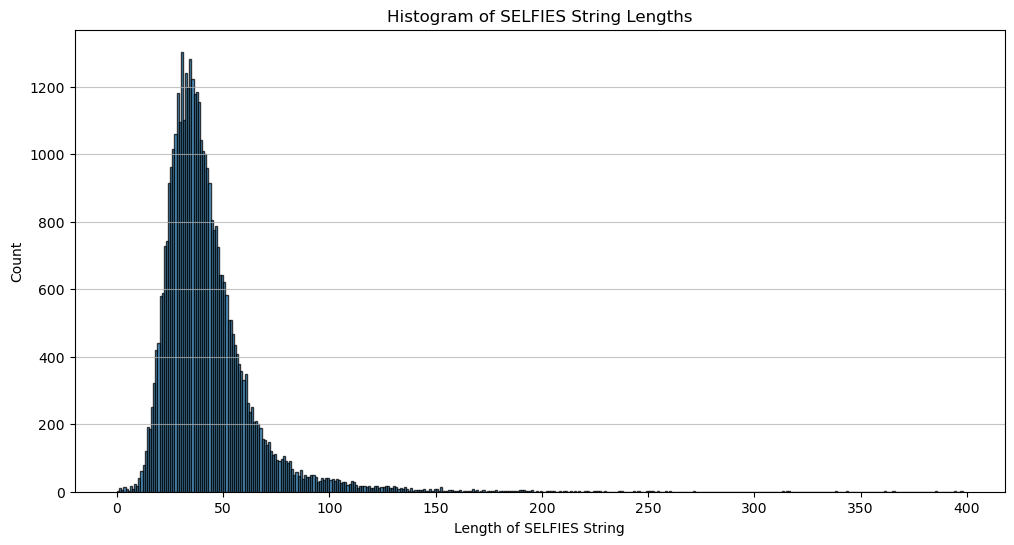

In [16]:
# Create a histogram
plt.figure(figsize=(12, 6))
plt.hist(len_sf, bins=range(min(len_sf), max(len_sf) + 1), alpha=0.75, edgecolor='black')
plt.title('Histogram of SELFIES String Lengths')
plt.xlabel('Length of SELFIES String')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Data sampling for the CNN-LSTM Autoencoder

In [18]:
# Separate the dataframe into three categories
df_CI = df_sf[df_sf['activity'] == 'CI']
df_CM = df_sf[df_sf['activity'] == 'CM']
df_CA = df_sf[df_sf['activity'] == 'CA']

# Randomly sample 300 from each category
sample_CI = df_CI.sample(n=400, random_state=42)  # replace 1 with your chosen seed for reproducibility
sample_CM = df_CM.sample(n=400, random_state=42)
sample_CA = df_CA.sample(n=400, random_state=42)

# Concatenate the samples back into one DataFrame
sampled_sf = pd.concat([sample_CI, sample_CM, sample_CA])

# If you want to shuffle the combined DataFrame
sampled_sf = sampled_sf.sample(frac=1).reset_index(drop=True)

In [19]:
sampled_sf.head()

,selfies,activity,HIV_active
0,[C][C][C][=C][Branch1][#Branch2][S][C][=C][C][...,CA,1
1,[C][C][C][C][C][C][=C][Branch2][Ring1][Branch1...,CM,1
2,[O][=C][Branch2][Ring1][#Branch2][N][C][C][=C]...,CA,1
3,[C][C][O][C][=C][C][=C][C][=C][Ring1][=Branch1...,CI,0
4,[C][O][C][=C][C][Branch1][C][C][=C][C][=C][Bra...,CA,1


## Padding, tokenization, and embedding

In [21]:
from torch.nn.utils.rnn import pad_sequence

In [22]:
def split_selfies(string_sf):
    # This regex matches anything inside brackets
    selfies_elements = re.findall(r'\[.*?]', string_sf)
    return selfies_elements

'''
# Example usage:
string_sf = df_sf.loc[0, 'selfies']
selfies_list = split_selfies(string_sf)
print(selfies_list)
'''

def pad_start_end_token(dataset):
    """
    Pad a list of SMILES with "SOS" and "EOS" token
    
    Parameters
    ----------
    smiles: list of str
        A list containing SMILES strings to pad
    
    Returns
    ------
    padded: list of list of str
        A list containing padded SMILES strings. Example: [['SOS', 'C', 'EOS'], ...]
    """
    padded = []
    for ind in range(len(dataset['selfies'])):
        padded.append(["[SOS]"] + split_selfies(df_sf.loc[ind, 'selfies']) + ["[EOS]"])
    return padded

In [23]:
padded_sf = pad_start_end_token(sampled_sf)
vocab = {element: idx for idx, element in enumerate(np.unique(np.concatenate(padded_sf)))}
vocab
#padded_sf[0]

{'[#Branch1]': 0,
 '[#Branch2]': 1,
 '[#C]': 2,
 '[#N]': 3,
 '[=As]': 4,
 '[=Branch1]': 5,
 '[=Branch2]': 6,
 '[=C]': 7,
 '[=N+1]': 8,
 '[=N]': 9,
 '[=O+1]': 10,
 '[=O]': 11,
 '[=P]': 12,
 '[=Ring1]': 13,
 '[=Ring2]': 14,
 '[=S+1]': 15,
 '[=S]': 16,
 '[=Se]': 17,
 '[Al]': 18,
 '[As]': 19,
 '[B-2]': 20,
 '[B]': 21,
 '[Bi]': 22,
 '[Br]': 23,
 '[Branch1]': 24,
 '[Branch2]': 25,
 '[CH1-1]': 26,
 '[C]': 27,
 '[Ca-2]': 28,
 '[Cl+3]': 29,
 '[Cl]': 30,
 '[Co-4]': 31,
 '[Cu-2]': 32,
 '[Cu-3]': 33,
 '[Cu-5]': 34,
 '[EOS]': 35,
 '[F]': 36,
 '[Fe-2]': 37,
 '[Fe-3]': 38,
 '[Fe-4]': 39,
 '[Hg-1]': 40,
 '[Hg-2]': 41,
 '[Hg]': 42,
 '[I]': 43,
 '[Li]': 44,
 '[Mn]': 45,
 '[N+1]': 46,
 '[N-1]': 47,
 '[NH1]': 48,
 '[N]': 49,
 '[Na]': 50,
 '[Ni-2]': 51,
 '[Ni-4]': 52,
 '[O+1]': 53,
 '[O-1]': 54,
 '[O]': 55,
 '[PH1]': 56,
 '[P]': 57,
 '[Pd-2]': 58,
 '[Ring1]': 59,
 '[Ring2]': 60,
 '[S+1]': 61,
 '[SOS]': 62,
 '[S]': 63,
 '[Sb]': 64,
 '[Se]': 65,
 '[SiH1]': 66,
 '[Si]': 67,
 '[Sn]': 68,
 '[V-1]': 69,
 '[Zn-2]

In [24]:
print(padded_sf[5])

['[SOS]', '[C]', '[C]', '[O]', '[P]', '[=Branch1]', '[C]', '[=O]', '[Branch1]', '[=N]', '[N]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[Branch1]', '[C]', '[Cl]', '[=C]', '[Ring1]', '[#Branch1]', '[O]', '[C]', '[C]', '[EOS]']


In [25]:
def tokenize_selfies(selfies_list, vocab):
    """Convert a list of SELFIES elements to a list of indices based on the vocabulary (One-hot encoding)."""
    return [vocab[element] for element in selfies_list if element in vocab]


In [26]:
tokenized_selfies = [tokenize_selfies(selfies, vocab) for selfies in padded_sf]

# Convert a list of tokenized selfies to a tensor and pass it through the embedding layer
# Pad the sequences to the same length to create a tensor
padded_tokenized_selfies = pad_sequence([torch.tensor(ts) for ts in tokenized_selfies],
                                        batch_first=True,
                                        padding_value=35)  # assuming 0 is the padding index

# Convert it to float type for the model
padded_tokenized_selfies = padded_tokenized_selfies.float()

# Print out the input dimension
print(padded_tokenized_selfies.shape)

# Print the dataset
PT_selfies_pd = pd.DataFrame(padded_tokenized_selfies)
PT_selfies_pd.head()

torch.Size([1200, 169])


,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,62.0,27.0,27.0,27.0,10.0,33.0,24.0,1.0,53.0,7.0,...,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0
1,62.0,27.0,5.0,1.0,7.0,27.0,7.0,27.0,7.0,27.0,...,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0
2,62.0,27.0,27.0,5.0,27.0,11.0,49.0,27.0,7.0,27.0,...,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0
3,62.0,49.0,27.0,7.0,27.0,7.0,25.0,59.0,5.0,27.0,...,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0
4,62.0,55.0,16.0,5.0,27.0,11.0,24.0,27.0,55.0,27.0,...,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0


In [27]:
# Find the maximum and minimum length of the tokenized sequences
max_length_tk_selfies = max(len(sequence) for sequence in tokenized_selfies)
min_length_tk_selfies = min(len(sequence) for sequence in tokenized_selfies)
print(f"The information of SELFIES dataset after tokenized",
      f"(length of selfies, maximum length of tokenized_selfies, minimum length of tokenized_selfies):")
print(len(tokenized_selfies),max_length_tk_selfies,min_length_tk_selfies)


# Find the maximum and minimum length of the tokenized sequences
max_length_pt_selfies = max(len(tensor) for tensor in padded_tokenized_selfies)
min_length_pt_selfies = min(len(tensor) for tensor in padded_tokenized_selfies)
print(f"The information of SELFIES dataset after tokenized",
      f"(length of selfies, maximum length of padded_tk_selfies, minimum length of padded_tk_selfies):")
print(len(padded_tokenized_selfies), max_length_pt_selfies, min_length_pt_selfies)


The information of SELFIES dataset after tokenized (length of selfies, maximum length of tokenized_selfies, minimum length of tokenized_selfies):
1200 169 4
The information of SELFIES dataset after tokenized (length of selfies, maximum length of padded_tk_selfies, minimum length of padded_tk_selfies):
1200 169 169


## CNN-LSTM Autoencoder

**Reference:** <br>
“Convolutional, Long Short-Term Memory, Fully Connected Deep Neural Networks.” IEEE Conference Publication | IEEE Xplore, 1 Apr. 2015, ieeexplore.ieee.org/document/7178838/authors#authors.

In [30]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [31]:
class SelfiesDataset(Dataset):
    def __init__(self, data):
        # Assuming data is a 3D tensor of shape (batch_size, sequence_length, embedding_dim)
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        # Assuming that the last dimension is the features/embedding dimension
        x = self.data[idx, :-1]  # All but the last feature. Use LSTM to predict the last position of series strings
        y = self.data[idx, 1:]   # All but the first feature (assuming you're predicting the next feature)
        '''
        For the calcuation of dimensionality
        #print(f"the shape of X:", x.shape)
        #print(f"the shape of y:", y.shape)
        '''
        return x,y


In [32]:
# Initialize dataset

# Split the data into training and validation sets
# Split indices into training and validation sets
train_indices, val_indices = train_test_split(range(len(padded_tokenized_selfies)), test_size=0.1, random_state=42)

# Create two separate datasets
train_dataset = torch.utils.data.Subset(SelfiesDataset(padded_tokenized_selfies), train_indices)
val_dataset = torch.utils.data.Subset(SelfiesDataset(padded_tokenized_selfies), val_indices)

In [33]:
# Calculate the dimension of CNN to ensure generating the length of strings
def CNN_out_dim(in_dim, kernel_size, padding, stride, dilation):
    return (in_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
sequence_length = padded_tokenized_selfies.shape[1]
Conv1d_out = CNN_out_dim(sequence_length, kernel_size=5, padding=2, stride=1, dilation=1)
Conv1d_out

169

In [34]:
# Model

class CNNLSTMEncoder(nn.Module):
    def __init__(self, input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length,lstm_num_layers, n_features):
        super(CNNLSTMEncoder, self).__init__()
        self.sequence_length = sequence_length
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.cnn = nn.Conv1d(
            in_channels=n_features, out_channels=cnn_channels,kernel_size=kernel_size, stride=1, padding=2
        )
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(
            input_size=cnn_channels, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True
        )

        # Additional layers to get the mean and log variance
        actual_length = sequence_length-1
        self.add_dim = nn.Linear(input_dim, n_features)
        self.mu = nn.Linear(lstm_hidden_size * actual_length, latent_dims)
        self.log_var = nn.Linear(lstm_hidden_size * actual_length, latent_dims)
        

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        batch_size = x.size(0)
        # Add a dummy dimension at the end so that x is [batch_size, sequence_length, 1]
        x = x.unsqueeze(-1)
        # Apply a linear layer - expecting [batch_size, sequence_length, n_features]
        x = self.add_dim(x)
        x = x.transpose(1, 2)  # Reshape to (batch_size, n_features, sequence_length)
        cnn_out = self.relu(self.cnn(x))
        cnn_out = cnn_out.transpose(1, 2)  # Reshape to (batch_size, sequence_length, cnn_channels)
        lstm_out, _ = self.lstm(cnn_out)
        
        
        # Flatten the output of LSTM to connect to fully connected layers
        lstm_out_flat = lstm_out.contiguous().view(batch_size, -1)
        mu = self.mu(lstm_out_flat).to(device)
        log_var = self.log_var(lstm_out_flat).to(device)

        '''
        #For the calculation of dimensionality:
        print(f"sequence_length:", sequence_length)
        print(f"input shape:", x.shape)
        print(f"batch size:", batch_size)
        print(f"after unsqueeze", x.shape)
        print(f"after add_dimension", x.shape)
        print(f"input size after transpose:", x.shape)
        print(f"output size after CNN and relu:", cnn_out.shape)
        print(f"size before the lstm:", cnn_out.shape)
        print(f"lstm_out:", lstm_out.shape)
        print(f"lstm_hidden_size:", lstm_hidden_size)
        print(f"sequence_length:", sequence_length)
        print(f"lstm_out_flat size:", lstm_out_flat.size())  # Debug print statement
        print(f"mu and log_var size:", mu.shape)
        print(f"lstm_out_flat:", lstm_out_flat.shape)
        '''
        
        return mu, log_var

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_hidden_size), 
                torch.zeros(self.num_layers, batch_size, self.lstm_hidden_size))

class CNNLSTMDecoder(nn.Module):
    def __init__(self, input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length,lstm_num_layers):
        super(CNNLSTMDecoder, self).__init__()
        self.sequence_length = sequence_length
        self.lstm_num_layers = lstm_num_layers
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm = nn.LSTM(
            input_size=lstm_hidden_size, hidden_size=cnn_channels, num_layers=lstm_num_layers, batch_first=True
        )
        self.relu = nn.ReLU()
        self.cnn = nn.ConvTranspose1d(
            in_channels=cnn_channels, out_channels=n_features, kernel_size=kernel_size, padding=kernel_size // 2
        )
        #self.decrease_dim = nn.Linear(input_dim*)
        actual_length = sequence_length-1
        self.translinear = nn.Linear(latent_dims, lstm_hidden_size * actual_length)
        self.unflatten = nn.Unflatten(1, (actual_length, lstm_hidden_size))
        self.red_dim = nn.Linear(n_features, input_dim)

    def forward(self, x):
        batch_size = x.size(0)
        linear_out = self.translinear(x)
        unflatten_out = self.unflatten(linear_out)
        lstm_out, _ = self.lstm(unflatten_out)
        lstm_out_trans = lstm_out.transpose(1, 2)  # Reshape to (batch_size, n_features, sequence_length)
        cnn_out = self.relu(self.cnn(lstm_out_trans))
        cnn_out_trans = cnn_out.transpose(1, 2)  # Reshape to (batch_size, sequence_length, input_dim)
        decoder_out = self.red_dim(cnn_out_trans)
        decoder_out = decoder_out.squeeze(-1)
        #print(f"decoder final output", decoder_out.shape)

        '''
        #For the calculation of dimensionality:
        print(f"decoder input shape:", x.shape)
        print(f"latent 2 lstm_hidden*sequence_length:", linear_out.shape)
        print(f"after unflatten:", unflatten_out.shape)
        print(f"decoder lstm_out:", lstm_out.shape)
        #print(f"decoder lstm_out after transpose:", lstm_out_trans.shape)
        print(f"output size after CNN and relu:", cnn_out.shape)
        print(f"cnn_out after transpose:", cnn_out_trans.shape)
        print(f"sequence_length:", sequence_length)
        print(f"decoder cnn_out:",cnn_out.shape)
        print(f"decoder final output", decoder_out.shape)
        '''
        
        return decoder_out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_hidden_size), 
                torch.zeros(self.num_layers, batch_size, self.lstm_hidden_size))

class CNNLSTMVAE(nn.Module):
    def __init__(
        self, input_dim, cnn_channels, kernel_size, 
        lstm_hidden_size, sequence_length, latent_dims, lstm_num_layers, n_features
    ):
        super(CNNLSTMVAE, self).__init__()
        self.encoder = CNNLSTMEncoder(
            input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length, lstm_num_layers, n_features
        )
        self.decoder = CNNLSTMDecoder(
            input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length, lstm_num_layers
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        
        # Reparameterization trick
        self.latent_dims = latent_dims
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var).to(device)
        eps = torch.randn_like(std).to(device)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        #print(f"Encoder is completed",mu.is_cuda, log_var.is_cuda)
        z = self.reparameterize(mu, log_var)
        #print(f"Reparameterize is completed",z.is_cuda,z.shape)
        decoded = self.decoder(z)
        return decoded, mu, log_var

    def init_hidden(self, batch_size):
        return (torch.zeros(self.lstm_num_layers, batch_size, self.lstm_hidden_size), 
                torch.zeros(self.lstm_num_layers, batch_size, self.lstm_hidden_size))

In [35]:
# loss function

def kld_loss_func(mu, sigma):
    """
    KL-Divergence: KLD = 0.5 * sum(\mu^2 + \sigma^2 - ln(\sigma^2) - 1)
    
    Parameters
    ----------
    mu: torch.Tensor
        Mean vector in the VAE bottleneck region
    sigma: torch.Tensor
        Standard Deviation vector in the VAE bottleneck region
    
    Return
    ------
    kld: torch.Tensor
        KL-Divegence loss (a scalar)
    """
    return 0.5 * torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1)

def mse_loss_func(recon_x, x):
    """
    Custom MSE loss calculation with padding handling.
    
    Parameters
    ----------
    recon_x : torch.Tensor
        Reconstructed data output by the VAE decoder.
    x : torch.Tensor
        Original input data to the VAE.
    
    Returns
    -------
    torch.Tensor
        Custom MSE loss considering padding.
    """

    # Create a mask that identifies where x is not equal to 0 (i.e., not padded)
    mask = (x != 0).float()

    # Calculate the squared difference, apply the mask, and sum
    squared_diff = (recon_x - x) ** 2
    masked_squared_diff = squared_diff * mask
    sum_squared_diff = masked_squared_diff.sum()

    # Calculate the number of non-padded elements
    num_non_padded = mask.sum()

    # Calculate the mean by dividing by the number of non-padded elements
    MSE_loss = sum_squared_diff / num_non_padded
    
    return MSE_loss


def vae_loss_func(recon_x, x, mu, sigma):
    #print(recon_x.shape)
    #mse_loss = F.mse_loss(recon_x, x, reduction='mean') 
    mse_loss = econ_loss = F.mse_loss(recon_x, x, reduction='mean')
    MSE_loss = mse_loss_func(recon_x, x)
    #print(f"mse loss", MSE_loss)
    kld_loss = kld_loss_func(mu, sigma)
    #print(f"kld loss", kld_loss)

    return mse_loss + kld_loss + MSE_loss

In [36]:
# The hyperparameter

'''
input_dim: Match the embedding dimension
cnn_channels: Number of CNN channels
kernel_size: Kernel size for the CNN
lstm_hidden_size: Hidden size for the LSTM
sequence_length: The length of the padded sequences
'''

input_dim = 1
cnn_channels = 16
kernel_size = 5  
lstm_hidden_size = 168  
sequence_length = padded_tokenized_selfies.shape[1]
num_epochs = 20
learning_rate=1e-3
l2=1e-5
latent_dims=64
batch_sizes=30
lstm_num_layers=1
n_features = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLvae = CNNLSTMVAE(
    input_dim, cnn_channels, kernel_size, lstm_hidden_size, sequence_length, latent_dims, lstm_num_layers, n_features
).to(device)

In [37]:
# VAE trainer

class VAETrainer:
    
    def __init__(self, model, learning_rate, batch_size, epoch, l2):
        self.model = model
        # use cuda if it is available
        if torch.cuda.is_available():
            model = model.cuda()  #  model
            
        # calulate the number of parameters    
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        
        self.epoch = epoch
        self.batch_size = batch_size
        

    
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list = []
        val_loss_list = []
        
        weights = self.model.state_dict()
        lowest_val_loss = np.inf

        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                if torch.cuda.is_available():
                    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                #print(X_batch.shape)
                batch_importance = 1 / len(train_data)
                # call the model
                hidden = self.model.init_hidden(y_batch.shape[0])
                self.model.hidden = self.model.init_hidden(y_batch.shape[0])
                X_batch_recon, mu, sigma = self.model(X_batch)
                #print(f"Shape of X_batch: {X_batch.shape}")
                #print(f"Shape of X_batch_recon: {X_batch_recon.shape}")
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)

                self.optimizer.zero_grad()
                batch_loss.backward(retain_graph=True)
                self.optimizer.step()
                
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            train_loss_list.append(epoch_loss)
            
            val_loss = self.evaluate(val_data, print_loss=False)
            val_loss_list.append(val_loss)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(x_axis, train_loss_list, label="Train")
            ax.plot(x_axis, val_loss_list, label="Validation")
            ax.set_title("Total Loss")
            ax.set_xlabel("# Epoch")

        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(x_axis, train_loss_list, label="Train")
            ax.plot(x_axis, val_loss_list, label="Validation")
            ax.set_title("Total Loss_log")
            ax.set_xlabel("# Epoch")
            ax.set_ylabel("Loss")
            ax.set_yscale('log')  # Set the y-axis to a logarithmic scale
            ax.legend()
            plt.show()

        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "val_loss_list": val_loss_list,
        }
    
    def evaluate(self, data, print_loss=True):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size)
        total_loss = 0.0
        for X_batch, y_batch in loader:
            if torch.cuda.is_available():
                 X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            
            with torch.no_grad():
                batch_importance = 1 / len(data)
                X_batch_recon, mu, sigma = self.model(X_batch)
                batch_loss = vae_loss_func(X_batch_recon, X_batch, mu, sigma)
                total_loss += batch_loss.detach().cpu().item() * batch_importance
        if print_loss:
            print(f"Total Loss: {total_loss}")
        return total_loss

CNNLSTMVAE - Number of parameters: 5589521


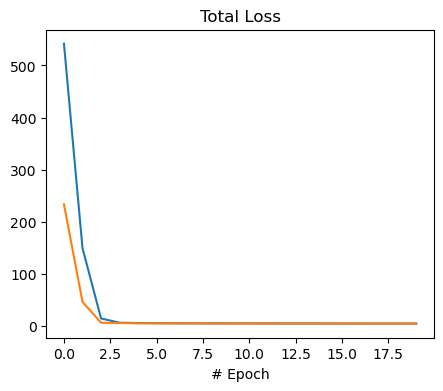

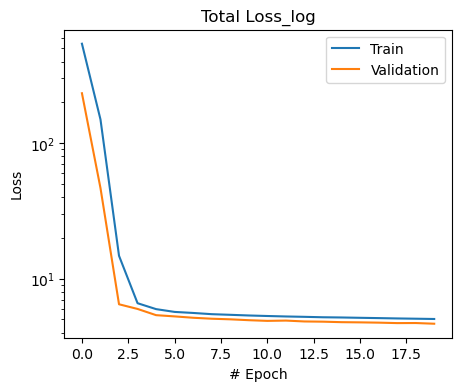

In [38]:
# Train the model

trainer = VAETrainer(model=CLvae, learning_rate=1e-3 ,  batch_size=30,  epoch=20, l2=1e-5)
# Train the VAE model with the trainer class
history = trainer.train(train_dataset, val_dataset)

In [39]:
print("Is CUDA Avauilable?", torch.cuda.is_available())

Is CUDA Avauilable? True


In [40]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


## Generate new molecules

In [42]:
# Get the data seed from the dataset of acitve molecules
sample_number = 150

data_seed = df_CA.sample(n=sample_number, random_state=42)
data_seed.head()

padded_dataseed = pad_start_end_token(data_seed)

tokenized_dataseed = [tokenize_selfies(selfies, vocab) for selfies in padded_dataseed] # The vocag should be same as the training set

# Convert a list of tokenized selfies to a tensor and pass it through the embedding layer
# Pad the sequences to the same length to create a tensor
padded_tokenized_dataseed = pad_sequence([torch.tensor(ts) for ts in tokenized_dataseed],
                                        batch_first=True,
                                        padding_value=0)  # assuming 0 is the padding index

# Convert it to float type for the model
padded_tokenized_dataseed = padded_tokenized_dataseed.float()

# Print out the input dimension
print(padded_tokenized_dataseed.shape)
print(f"The longest sequence in this dataseed:", padded_tokenized_dataseed.shape[1])

# Print the dataset
PT_dataseed_pd = pd.DataFrame(padded_tokenized_dataseed)
PT_dataseed_pd.head()

torch.Size([150, 83])
The longest sequence in this dataseed: 83


,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,62.0,27.0,27.0,27.0,10.0,33.0,24.0,1.0,53.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,62.0,27.0,5.0,1.0,7.0,27.0,7.0,27.0,7.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62.0,27.0,27.0,5.0,27.0,11.0,49.0,27.0,7.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62.0,49.0,27.0,7.0,27.0,7.0,25.0,59.0,5.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,62.0,55.0,16.0,5.0,27.0,11.0,24.0,27.0,55.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Make the sequence as long as the training dataset
# ** Actual length = sequence_length-1
if padded_tokenized_selfies.shape[1]!=padded_tokenized_dataseed.shape[1]:
    zero_pad = torch.zeros(sample_number, (padded_tokenized_selfies.shape[1]-padded_tokenized_dataseed.shape[1]-1))
    PT_dataseed = torch.cat((padded_tokenized_dataseed, zero_pad), dim=1)
else:
    PT_dataseed = padded_tokenized_dataseed

# Print the dataset
dataseed_pd = pd.DataFrame(PT_dataseed)
dataseed_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,62.0,27.0,27.0,27.0,10.0,33.0,24.0,1.0,53.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,62.0,27.0,5.0,1.0,7.0,27.0,7.0,27.0,7.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62.0,27.0,27.0,5.0,27.0,11.0,49.0,27.0,7.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62.0,49.0,27.0,7.0,27.0,7.0,25.0,59.0,5.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,62.0,55.0,16.0,5.0,27.0,11.0,24.0,27.0,55.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Obatain the latent vectors (feature vectors)

def get_latent_vectors(model, X):
    with torch.no_grad():
        # Move model to CPU
        model = model.to('cpu')
        # Ensure the input tensor is also on CPU
        X = X.to('cpu')
        mu, log_var = model.encoder(X)
    return mu, log_var

mu_dataseed, log_var_dataseed = get_latent_vectors(trainer.model, PT_dataseed)
print(f"The shape of the mu and log_var: (mu, log_var)", mu_dataseed.shape, log_var_dataseed.shape)

The shape of the mu and log_var: (mu, log_var) torch.Size([150, 64]) torch.Size([150, 64])


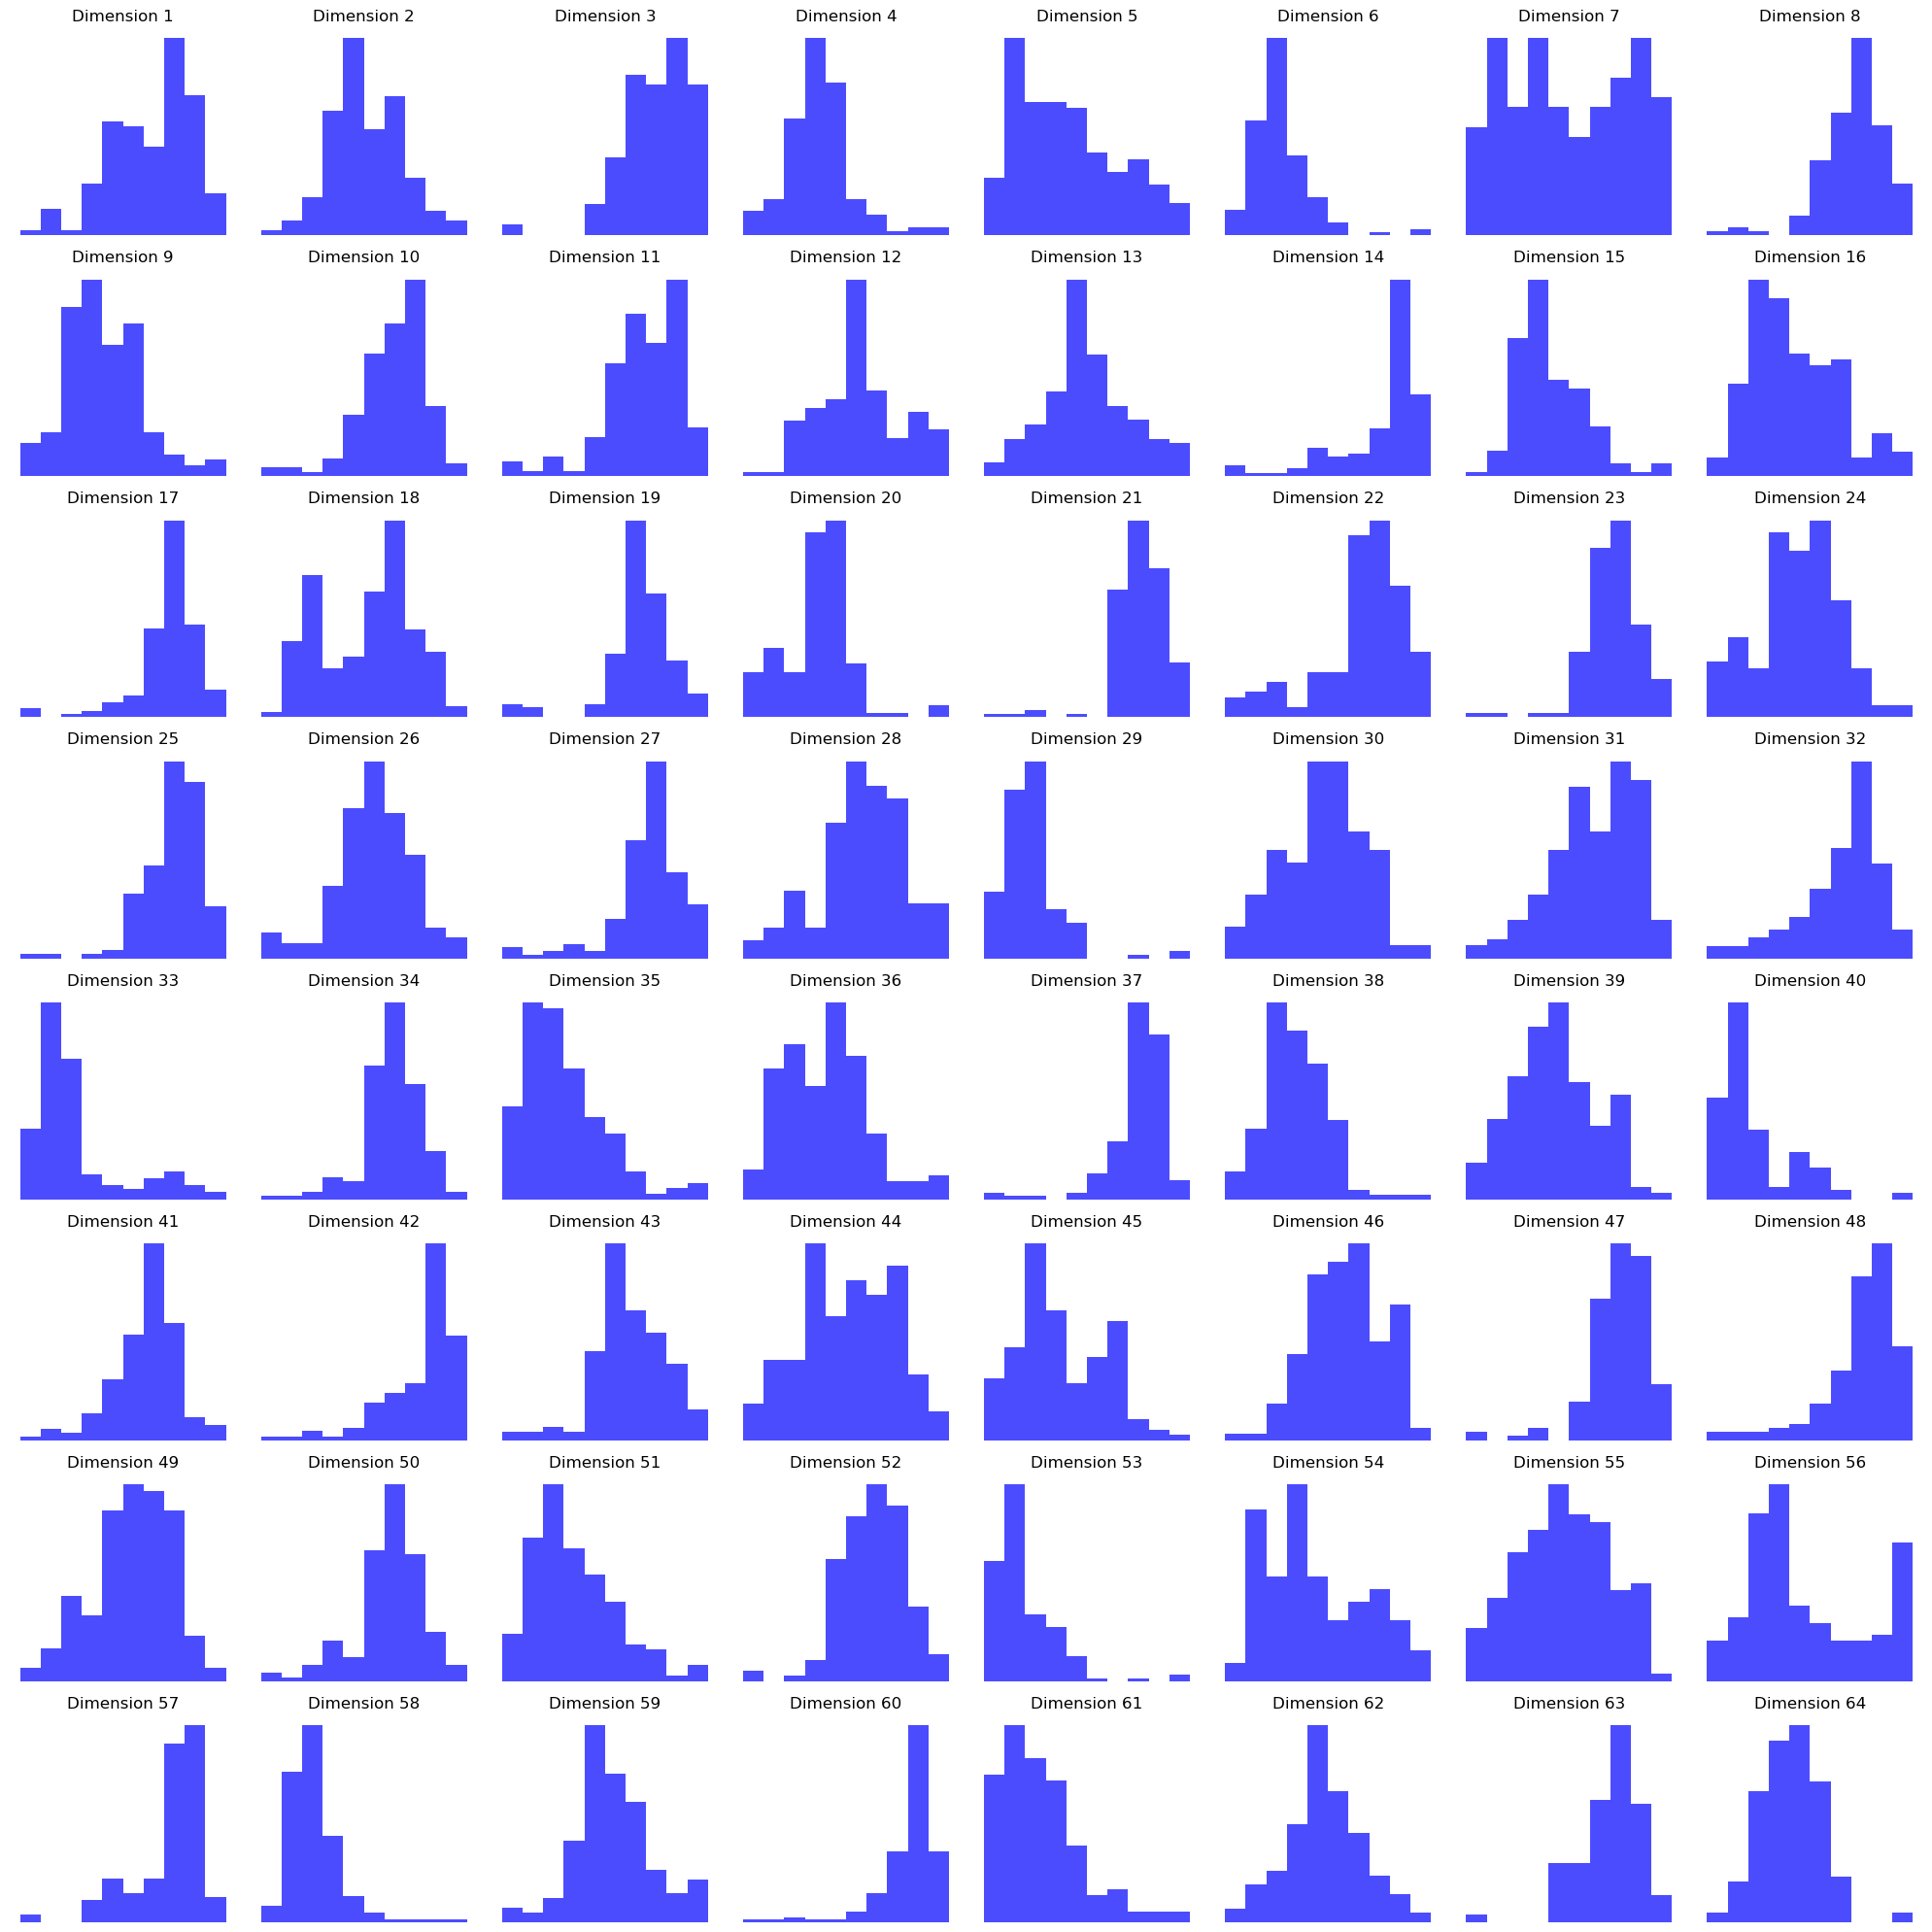

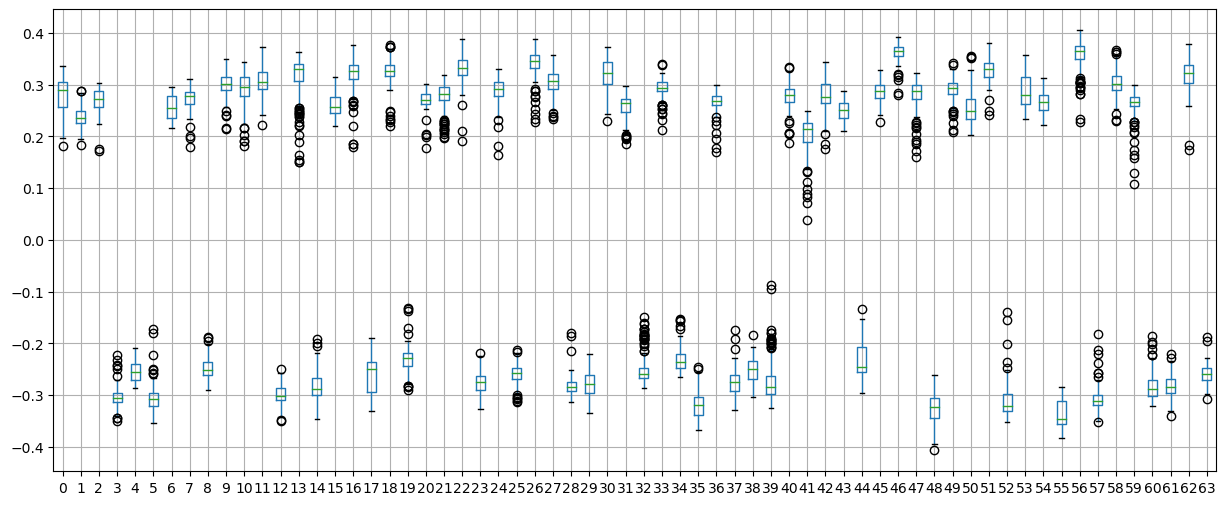

In [45]:
# Analyze the distribution of mu

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume 'data' is a Pandas DataFrame where each column is a dimension
data = pd.DataFrame(mu_dataseed.cpu())  # Example data

# Summary statistics
#print(data.describe())

# Histograms for each dimension
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
axes = axes.ravel()
for i, ax in enumerate(axes):
    if i < 64:
        ax.hist(data.iloc[:, i], bins=10, color='blue', alpha=0.7)
        ax.set_title(f'Dimension {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Box plots
data.boxplot(figsize=(15, 6))
plt.show()


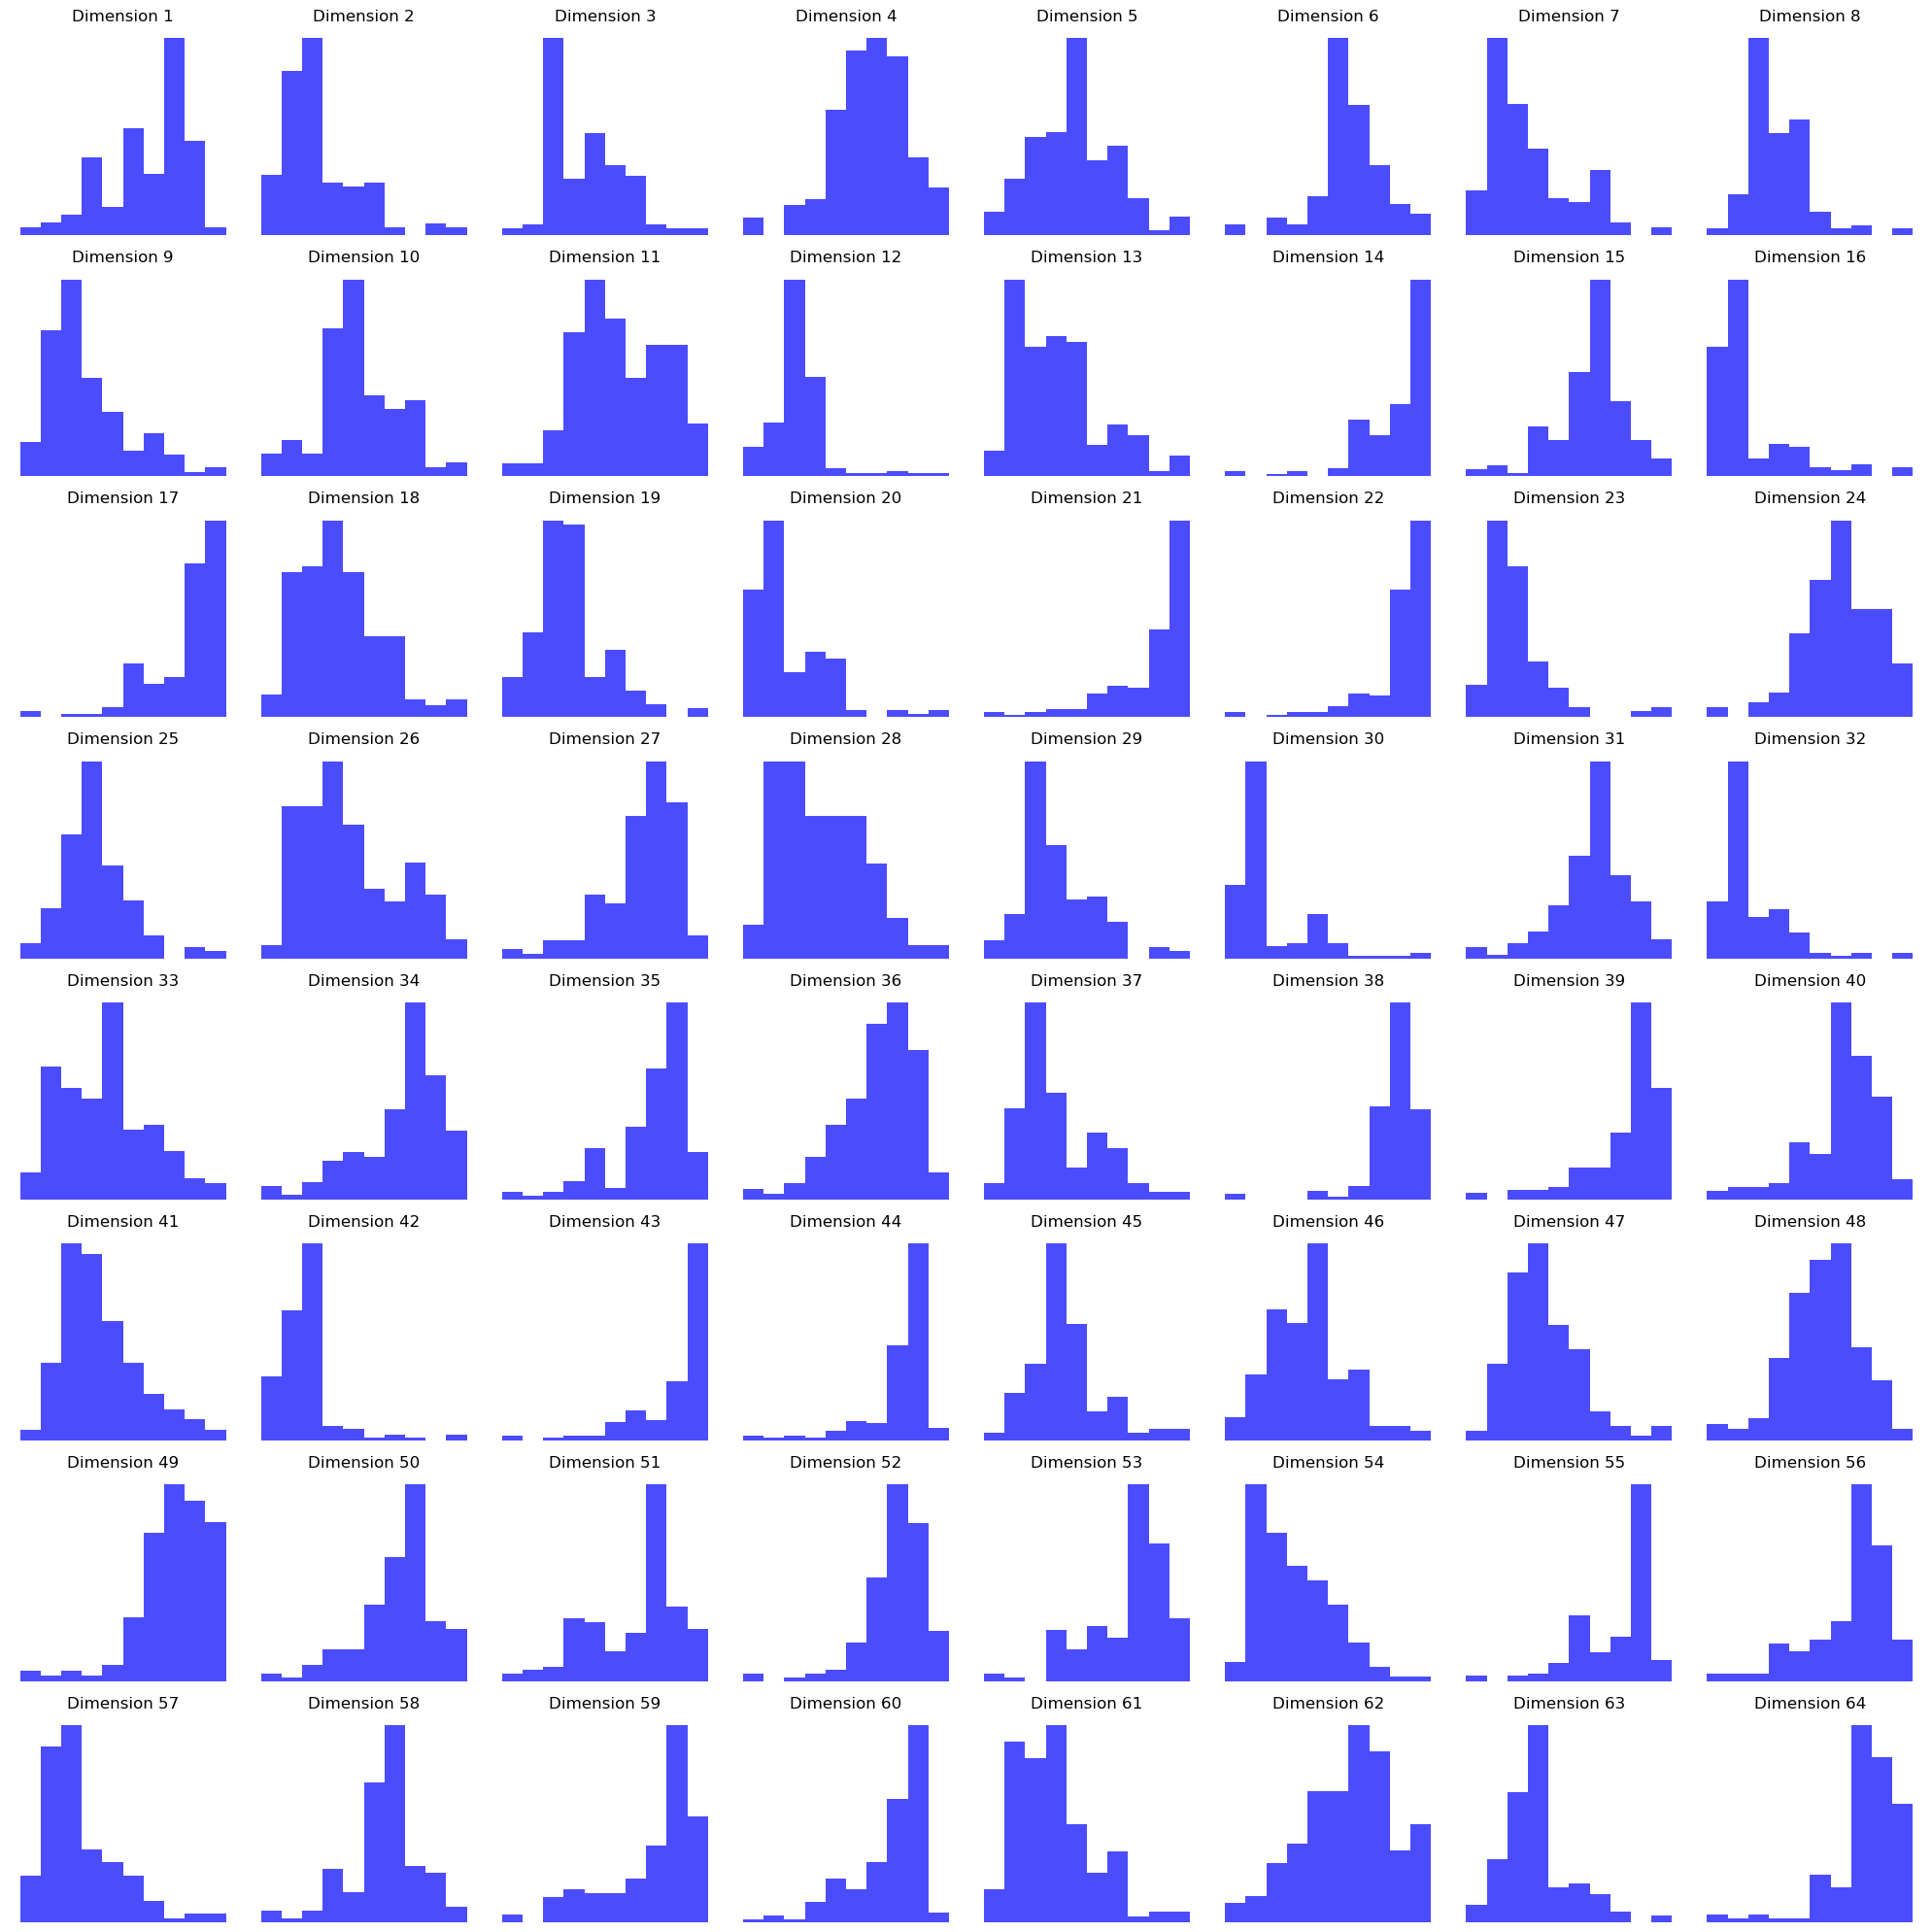

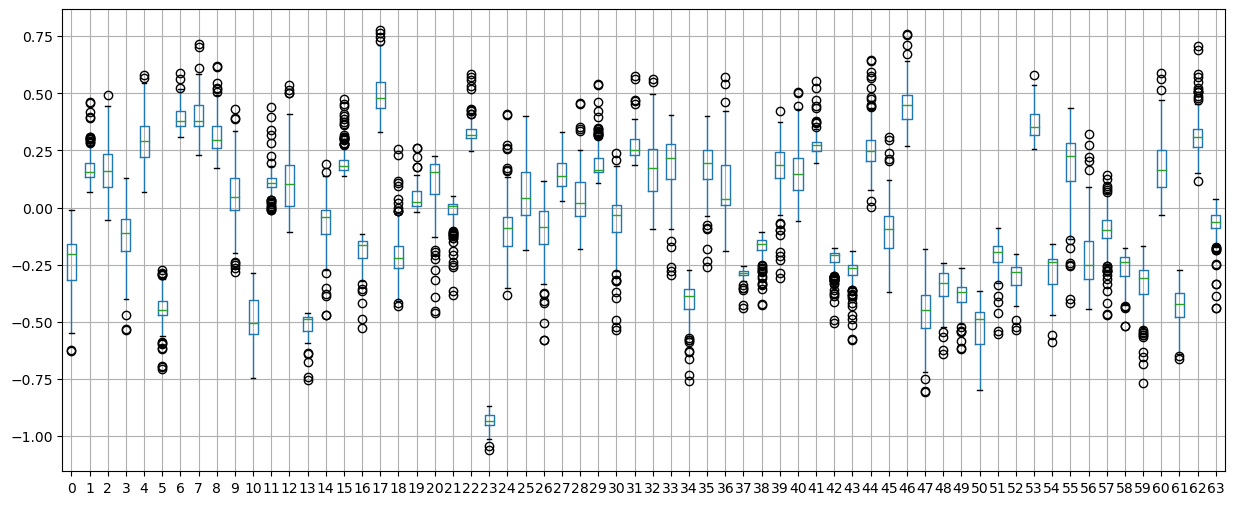

In [46]:
# Analyze the distribution of log_var

data = pd.DataFrame(log_var_dataseed.cpu())  # Example data

# Summary statistics
#print(data.describe())

# Histograms for each dimension
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
axes = axes.ravel()
for i, ax in enumerate(axes):
    if i < 64:
        ax.hist(data.iloc[:, i], bins=10, color='blue', alpha=0.7)
        ax.set_title(f'Dimension {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Box plots
data.boxplot(figsize=(15, 6))
plt.show()

In [47]:
import numpy as np
from scipy.stats import gaussian_kde

# Assuming 'data' is a DataFrame or a 2D numpy array with your 20x64 dataset
mu_dataseed = mu_dataseed.cpu()
n_samples = 15  # The number of samples you want from each distribution
dimensions = latent_dims

def generate_new_feature_vectors(data_seed,n_samples,dimensions):
    # Initialize an empty list to hold the sampled data
    samples_list = []

    for i in range(dimensions):  # Assuming there are 64 dimensions
        # Get the i-th dimension data
        dimension_data = mu_dataseed[:, i]  # Replace with appropriate data retrieval if using a DataFrame
        
        # Create a gaussian_kde object for the i-th dimension
        kde = gaussian_kde(dimension_data)
        
        # Sample 10 data points from the kde of the i-th dimension
        dimension_samples = kde.resample(size=n_samples,seed=42)
        
        # Flatten the array and append the samples to our list
        samples_list.append(dimension_samples.flatten())
        
    # Convert the list of samples into a 10x64 numpy array (tensor)
    tensor = np.array(samples_list).T  # Transpose to get the desired shape
    return tensor

mu_new = generate_new_feature_vectors(mu_dataseed, n_samples, dimensions)
log_var_new = generate_new_feature_vectors(log_var_dataseed, n_samples, dimensions)

In [48]:
print("Is CUDA Avauilable?", torch.cuda.is_available())

Is CUDA Avauilable? True


In [49]:
# Reparameterize and decode the new latent vectors (feature_vectors)
def decode_new_vectors(model, mu, log_var):
    with torch.no_grad():
        # Move model to the appropriate device (CPU or CUDA)
        model = model.cuda()
        
        # Ensure the input tensor is also on the same device
        mu = torch.from_numpy(mu).float().cuda()
        log_var = torch.from_numpy(log_var).float().cuda()

        z = model.reparameterize(mu, log_var)
        print(f"Reparameterize is completed. (mu.shape, log_var.shape, z.shape)",mu.shape,log_var.shape,z.shape)

        new_reconstructed = model.decoder(z)

    return new_reconstructed

new_molecules = decode_new_vectors(trainer.model, mu_new, log_var_new)
print(f"The shape of new reconstructed data", new_molecules.shape)
print(f"The new reconstructed data", new_molecules)

Reparameterize is completed. (mu.shape, log_var.shape, z.shape) torch.Size([15, 64]) torch.Size([15, 64]) torch.Size([15, 64])
The shape of new reconstructed data torch.Size([15, 168])
The new reconstructed data tensor([[28.0958, 31.7846, 32.3497,  ..., 39.5365, 31.8576, 22.8339],
        [27.9291, 30.4600, 31.9767,  ..., 39.1083, 31.4976, 22.7906],
        [27.8637, 31.7047, 33.6024,  ..., 38.8149, 31.2978, 22.5819],
        ...,
        [27.7979, 30.0152, 30.5896,  ..., 38.7715, 31.1142, 22.6641],
        [27.5334, 29.9854, 31.4553,  ..., 38.9496, 31.2504, 22.5138],
        [28.3432, 31.9119, 30.6975,  ..., 40.2472, 32.2358, 22.9369]],
       device='cuda:0')


In [50]:
# Round the values to the nearest integer
rounded_molecules = new_molecules.round()

# If you need to use these as indices, convert to integer type
indices_molecules = rounded_molecules.int()  # or .long() for 64-bit integers

print(indices_molecules)

tensor([[28, 32, 32,  ..., 40, 32, 23],
        [28, 30, 32,  ..., 39, 31, 23],
        [28, 32, 34,  ..., 39, 31, 23],
        ...,
        [28, 30, 31,  ..., 39, 31, 23],
        [28, 30, 31,  ..., 39, 31, 23],
        [28, 32, 31,  ..., 40, 32, 23]], device='cuda:0', dtype=torch.int32)


In [51]:
def detokenize_selfies(indices, vocab):
    """Convert a 2D array of indices to a list of lists of SELFIES elements using the inverted vocabulary."""
    selfies_elements = []
    for index_array in indices:
        element_list = []
        for idx in index_array:
            if idx in vocab:
                element_list.append(vocab[idx])
            else:
                print(f"Index {idx} not in vocabulary")
        selfies_elements.append(element_list)
    return selfies_elements

# Assuming indices_molecules_cpu is a 2D tensor, convert it to numpy and call the function
inv_vocab = {v: k for k, v in vocab.items()}  # Invert the vocab
new_selfies = detokenize_selfies(indices_molecules.cpu().numpy(), inv_vocab)  # Use inverted vocab
print(len(new_selfies))
print(new_selfies[2])

15
['[Ca-2]', '[Cu-2]', '[Cu-5]', '[Cl]', '[CH1-1]', '[Branch1]', '[Branch2]', '[Ca-2]', '[Cl]', '[Co-4]', '[Co-4]', '[Co-4]', '[Co-4]', '[Co-4]', '[Cl]', '[Cl]', '[Co-4]', '[Cu-3]', '[Cu-5]', '[EOS]', '[F]', '[Cu-5]', '[Co-4]', '[Cl]', '[Cl]', '[Cl]', '[Co-4]', '[Cu-2]', '[Cu-2]', '[Cu-3]', '[Cu-3]', '[Cu-5]', '[Cu-5]', '[EOS]', '[EOS]', '[EOS]', '[Cu-5]', '[Cu-3]', '[Cu-2]', '[Cu-3]', '[Cu-3]', '[Cu-5]', '[EOS]', '[F]', '[F]', '[EOS]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-5]', '[Cu-5]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-5]', '[Cu-5]', '[EOS]', '[EOS]', '[F]', '[F]', '[EOS]', '[Cu-5]', '[Cu-5]', '[EOS]', '[F]', '[EOS]', '[EOS]', '[Cu-5]', '[Cu-5]', '[EOS]', '[F]', '[F]', '[F]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[F]', '[EOS]', '[EOS]', '[EOS]', '[EOS]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[EOS]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[Cu-5]', '[Cu-

**We cut off the string when the first 'EOS' appears!**

In [53]:
def cut_selfies(selfies):
    new_selfies = []
    for selfies_list in selfies:
        # Find the index of the first '[EOS]' occurrence
        first_eos_index = selfies_list.index('[EOS]') if '[EOS]' in selfies_list else None
        # Take the sublist up to the first '[EOS]' (exclusive)
        if first_eos_index is not None:
            truncated_selfies_list = selfies_list[:first_eos_index]
        else:
            truncated_selfies_list = selfies_list  # No '[EOS]' found, return the list as is
        new_selfies.append(truncated_selfies_list)
    return new_selfies

# Use the function like this
short_selfies = cut_selfies(new_selfies)
print(short_selfies[3])

['[Ca-2]', '[Co-4]', '[Co-4]', '[Ca-2]', '[CH1-1]', '[Branch2]', '[CH1-1]', '[Ca-2]', '[C]', '[Ca-2]', '[C]', '[Ca-2]', '[Ca-2]', '[Ca-2]', '[Ca-2]', '[Cl+3]', '[Cl+3]', '[Cl]', '[Cl]', '[Co-4]', '[Cu-2]', '[Cu-3]', '[Cu-2]', '[Cu-2]', '[Cu-3]', '[Cu-2]', '[Cu-3]', '[Cu-3]', '[Cu-5]', '[Cu-3]', '[Cu-2]', '[Cu-2]', '[Co-4]', '[Cl]', '[Cl]', '[Cl]', '[Cl]', '[Co-4]', '[Co-4]', '[Cu-2]', '[Cu-2]', '[Cu-2]', '[Cu-2]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-3]', '[Cu-5]', '[Cu-2]', '[Cu-2]', '[Co-4]', '[Cu-3]', '[Cu-3]', '[Cu-5]']


In [54]:
def convert_indices_to_smiles(selfies_elements):
    """Convert generated indices back to a SMILES string."""
    smiles_strs = []
    for selfies_list in selfies_elements:
        selfies_string = "".join(selfies_list)  # Change here to selfies_list
        smiles_string = sf.decoder(selfies_string)
        smiles_strs.append(smiles_string)
    return smiles_strs

new_smiles = convert_indices_to_smiles(short_selfies)
print(new_smiles)


['[Ca-2][Cu-2][Cu-2][Cl+3]C(C)[Cl+3][Cl+3]Cl', '[Ca-2]Cl', '[Ca-2][Cu-2][Cu-5]Cl', '[Ca-2][Co-4][Co-4][Ca-2][CH1-1][CH1-1][Ca-2]C[Ca-2]C[Ca-2][Ca-2][Ca-2][Ca-2][Cl+3][Cl+3]Cl', '[Ca-2][Co-4][Cu-2]Cl', '[Cl+3][Cu-3][Co-4]([CH1-1][Ca-2][Co-4][Cu-3][Cu-2][Cl+3])C[Ca-2][Cl+3]Cl', '[Ca-2][Cu-2][Cu-2][Ca-2]C[CH1-1][Ca-2][Cl+3]Cl', '[Ca-2][Cu-2][Cu-3][Cl+3]C(Cl)[Co-4]Cl', '[Ca-2][Cu-2][Co-4][CH1-1]Br', 'C[Co-4][Co-4]C[CH1-1]C(C[Cl+3][Cl+3]Cl)[Cu-3][Cu-3][Co-4]Cl', '[Ca-2][Cu-2][Co-4][Ca-2][Ca-2][Ca-2]C[Ca-2][Ca-2][Cl+3]Cl', '[Cl+3][Cu-2]Cl', '[Ca-2]Cl', '[Ca-2]Cl', '[Ca-2][Cu-2][Co-4]C[Cl+3]Cl']


In [55]:
from rdkit import Chem

def validate_smiles_strs(smiles_string):
    valid = []
    for smile in smiles_string:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            valid.append(mol)
    print(f"Number of valid SMILES: {len(valid)}")
    return valid

validation = validate_smiles_strs(new_smiles)

Number of valid SMILES: 15


## Compare the new data with the original dataset

In [57]:
def compare_dataset(dataset, new_smiles):
    existing_indices = []
    truly_new_smiles = []

    # Iterate over the new SMILES strings
    for smi in new_smiles:
        if smi in df['smiles'].values:  # Assuming 'smiles' is the column name with SMILES strings in df
            existing_indices.append(df.index[df['smiles'] == smi].tolist())  # Append the index(es) where the SMILES string was found
        else:
            truly_new_smiles.append(smi)  # Append the SMILES string if it is new
    
    # Flatten the list of indices if you expect only unique entries in df
    existing_indices = [idx for sublist in existing_indices for idx in sublist]
    
    print("Indices of existing SMILES strings:", existing_indices)
    print("Truly new SMILES strings:", truly_new_smiles)
    print("The amount of truly new SMILES string:", len(truly_new_smiles))
    return existing_indices, truly_new_smiles

exsiting_smiles, truenew_smiles = compare_dataset(df, new_smiles)

Indices of existing SMILES strings: []
Truly new SMILES strings: ['[Ca-2][Cu-2][Cu-2][Cl+3]C(C)[Cl+3][Cl+3]Cl', '[Ca-2]Cl', '[Ca-2][Cu-2][Cu-5]Cl', '[Ca-2][Co-4][Co-4][Ca-2][CH1-1][CH1-1][Ca-2]C[Ca-2]C[Ca-2][Ca-2][Ca-2][Ca-2][Cl+3][Cl+3]Cl', '[Ca-2][Co-4][Cu-2]Cl', '[Cl+3][Cu-3][Co-4]([CH1-1][Ca-2][Co-4][Cu-3][Cu-2][Cl+3])C[Ca-2][Cl+3]Cl', '[Ca-2][Cu-2][Cu-2][Ca-2]C[CH1-1][Ca-2][Cl+3]Cl', '[Ca-2][Cu-2][Cu-3][Cl+3]C(Cl)[Co-4]Cl', '[Ca-2][Cu-2][Co-4][CH1-1]Br', 'C[Co-4][Co-4]C[CH1-1]C(C[Cl+3][Cl+3]Cl)[Cu-3][Cu-3][Co-4]Cl', '[Ca-2][Cu-2][Co-4][Ca-2][Ca-2][Ca-2]C[Ca-2][Ca-2][Cl+3]Cl', '[Cl+3][Cu-2]Cl', '[Ca-2]Cl', '[Ca-2]Cl', '[Ca-2][Cu-2][Co-4]C[Cl+3]Cl']
The amount of truly new SMILES string: 15


## Ask ChatGPT whether the unseen strings exist in real world

Set up the ChatGPT assistant

Prompt: Does [SMILES string] exist in the world? Does it follow the molecular bonding rules and molecular compound rules

In [79]:
from openai import OpenAI

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key="sk-proj-bKBNtU2rrgMV59PGcTnST3BlbkFJY9QAG8OOGCAFKYOCG6qK",
)

def chat_gpt(prompt):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )
    return response  # Return the full response object

In [ ]:
messages = [{"role": "system", "content": "You are an intelligent assistant."}]
while True:
    user_input = input("User: ")
    messages.append({"role": "user", "content": user_input})
    response = chat_gpt(user_input)
    
    # Accessing the response correctly
    assistant_response = response.choices[0].message.content
    print(f"Assistant: {assistant_response}")
    messages.append({"role": "assistant", "content": assistant_response})

User:  Does [Ca-2][Co-4][Cu-2]Cl exist in the world? Does it follow the molecular bonding rules and molecular compound rules


Assistant: There is no known compound with the formula [Ca-2][Co-4][Cu-2]Cl. The formula does not follow the typical molecular bonding rules and molecular compound rules. It is not clear what the intended composition or structure of this compound would be based on the given formula.


User:  Can you analyze this [Ca-2][Co-4][Cu-2]Cl SMILES string and determine if a molecule with that specific structure exists?


Assistant: In the SMILES string [Ca-2][Co-4][Cu-2]Cl, the square brackets indicate the number of atoms for each element. However, the representation used here is not standard SMILES notation and there is no direct chemical interpretation.

Typically, in SMILES notation, the molecular structure is represented using standard symbols for each element, with numerical indices indicating the number of that element present in the molecule. For example, the SMILES string for calcium chloride would be "[Ca+2].[Cl-]", indicating one calcium atom with a charge of +2 and one chloride atom with a charge of -1.

Without the use of standard notation in the provided SMILES string, it is not possible to accurately determine if a molecule with the specific structure exists.
